# Objetivos:
Como funciona agrupamiento espacial: cada fila es una ubicación geográfica, se extrae información de la serie asociada a esa ubicación (estática como promedio, min, max, std) y dependiente del tiempo (o frecuencia). Luego con esta información aplica algoritmos de clustering para agrupar las ubicaciones geográficas con características similares.

**Agrupar datos por su similaridad para caracterizar los distintos grupos  de datos formados**. Nótese que la agrupación puede temporal (detectando patrones en los eventos que ocurren en un intervalo de tiempo) o espacial (agrupan ubicaciones con caracteristicas similares).

**Fun Fact para visualización:** Al juntar cada dato por columna, se podria ver como una imagen, si se normaliza cada valor para que esté entre 0 y 255 (o 0 y 1), podría ser interesante ver esas evoluciones con un heatmap donde cada fila sea la cantidad de salidas en un intervalo especifico y cada columna representa el día del mes en el que se tomó la muestra

- Hacer un análisis descriptivo y estadístico de los datos por día, mes  (temporal, como comparativo entre estaciones o Zonas)
    - Tendencia, estacionalidad, periodicidad
    - Graficas de autocorrelación
    - Suavizado de las gráficas
- Agrupar salidas acorde a su comportamiento.
    - Por franjas horarias en un solo día
    - Entre con las de solo un mes
    - Entre varios meses
    
    - Por Zona
    
**Nota:** Hacer test Dickey Fuller

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## 1. Lectura de datos

In [2]:
df = pd.read_csv("consolidado-de-salidas-sistema-troncal-por-franja-horaria-enero-abril-2020.csv",
                 encoding='latin-1', header=0,sep=';')

C:\Users\juanc\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (34,35) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
df = df.drop(columns=["Unnamed: 37","Unnamed: 38"])

In [4]:
print(df.columns)

Index(['Zona', 'Estación', 'Acceso de Estación', 'Mes', 'INTERVALO', 'Día 1',
       'Día 2', 'Día 3', 'Día 4', 'Día 5', 'Día 6', 'Día 7', 'Día 8', 'Día 9',
       'Día 10', 'Día 11', 'Día 12', 'Día 13', 'Día 14', 'Día 15', 'Día 16',
       'Día 17', 'Día 18', 'Día 19', 'Día 20', 'Día 21', 'Día 22', 'Día 23',
       'Día 24', 'Día 25', 'Día 26', 'Día 27', 'Día 28', 'Día 29', 'Día 30',
       'Día 31', 'Total general'],
      dtype='object')


In [5]:
# IDentificador del sistema de la zona troncal
df["Zona"].value_counts()

(34) Zona H Caracas Sur       24959
(33) Zona B AutoNorte         21697
(30) Zona G NQS Sur           21690
(12) Zona L Carrera 10        21334
(31) Zona F Av. Américas      18848
(35) Zona D Calle 80          16716
(36) Zona A Caracas           15454
(38) Zona E NQS Central       14937
(32) Zona C Av. Suba          14584
(11) Zona K Calle 26          13589
(39) Zona F Calle 13           8527
(37) Zona J Eje Ambiental      3913
(40) Zona T Ciudad Bolívar     2135
Name: Zona, dtype: int64

In [6]:
print("Cantidad de estaciones: ",len(df["Estación"].value_counts()))
print("Cantidad de accesos a estacion: ",len(df['Acceso de Estación'].value_counts()))

Cantidad de estaciones:  159
Cantidad de accesos a estacion:  400


Por simplicidad se hará inicialmente el análisis con una zola estación, en este caso con la primera que sale en el dataframe.

In [7]:
df_p_dorado = df[df["Estación"]=="(06000) Portal Eldorado"]
print("Dimensiones de registros para el portal el dorado: ",df_p_dorado.shape)

Dimensiones de registros para el portal el dorado:  (3285, 37)


In [8]:
df_p_dorado.isna().sum()

Zona                  0
Estación              0
Acceso de Estación    0
Mes                   0
INTERVALO             0
Día 1                 0
Día 2                 0
Día 3                 0
Día 4                 0
Día 5                 0
Día 6                 0
Día 7                 0
Día 8                 0
Día 9                 0
Día 10                0
Día 11                0
Día 12                0
Día 13                0
Día 14                0
Día 15                0
Día 16                0
Día 17                0
Día 18                0
Día 19                0
Día 20                0
Día 21                0
Día 22                0
Día 23                0
Día 24                0
Día 25                0
Día 26                0
Día 27                0
Día 28                0
Día 29                0
Día 30                0
Día 31                0
Total general         0
dtype: int64

Afortunadamente, ningun valor falta en este subconjunto de datos. Ahora analicemos cuantos accesos tiene esta estación

In [9]:
df_p_dorado['Acceso de Estación'].value_counts()

(02) PLAT1 ALIM-ENGATIVÁ/LAFAENA/TIERRAGRATA/AEROPUERTO/ELMUELLE/AV.ELDORADO ALAMOS/VILLAAMALIA          356
(01) PLAT2 ALIM-DESAL FONTIBÓN/FONTIBÓN CENTRO/VILLEMAR/CALIHAYUELOS/LAESTANCIA/ZONA FRANCA/BELÉN-TC6    356
(04) Acceso Peatonal Occidental                                                                          356
(03) Acceso Peatonal Oriental                                                                            356
(18) Acceso Peatonal Oriental (Discapacidad)                                                             355
(19) Acceso Peatonal Occidental (Discapacidad)                                                           355
(17) P1ALIM-ENGATIVÁ/LAFAENA/TIERRAGRATA/AEROPUERTO/ELMUELLE/AV.ELDORADOALAMOS/VILLAAMALIA(DISCAP)       355
(24) Acceso Bicicletero                                                                                  354
(16) P2 A-D FONTIBÓN/FONTIBÓNCENTRO/VILLEMAR/CALIHAYUELOS/LAESTANCIA/ZONAFRANCA/BELÉN-TC6(DISCAP)        354
CENTRO             

Vemos que todos los accesos al Portal el Dorado tienen 356 registros a excepción del acceso (16) el cual solo tiene 88 registros. Ahora obtengamos unas primeras visualizaciones de las salidas

In [10]:
# Finalmente filtrando por mes y nombre de la estacion se obtiene un dia
cod_acceso = "(04)"
mes="Enero"
df2 = df_p_dorado[(df_p_dorado["Mes"]==mes) & (df_p_dorado["Acceso de Estación"].str.contains(cod_acceso))]

C:\Users\juanc\anaconda3\lib\site-packages\pandas\core\strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [11]:
df2.shape

(89, 37)

**Nota:** Solo hay 89 muestras y no 96 porque en el ubtervalo de 1 a 3 am excluyendo los límites, no hay muestras cada 3 minutos.

In [12]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89 entries, 267 to 355
Data columns (total 37 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Zona                89 non-null     object 
 1   Estación            89 non-null     object 
 2   Acceso de Estación  89 non-null     object 
 3   Mes                 89 non-null     object 
 4   INTERVALO           89 non-null     object 
 5   Día 1               89 non-null     int64  
 6   Día 2               89 non-null     float64
 7   Día 3               89 non-null     float64
 8   Día 4               89 non-null     float64
 9   Día 5               89 non-null     float64
 10  Día 6               89 non-null     float64
 11  Día 7               89 non-null     float64
 12  Día 8               89 non-null     float64
 13  Día 9               89 non-null     float64
 14  Día 10              89 non-null     float64
 15  Día 11              89 non-null     float64
 16  Día 12 

In [25]:
# Día 30 y Día 31 aparecen como object, los cambiamos a float
df2 = df2.astype({"Día 30":float, "Día 31":float})

In [30]:
prom_salidas_dia = df2.loc[:,"Día 1":"Día 31"].values.sum(axis=1)*(1.0/31)

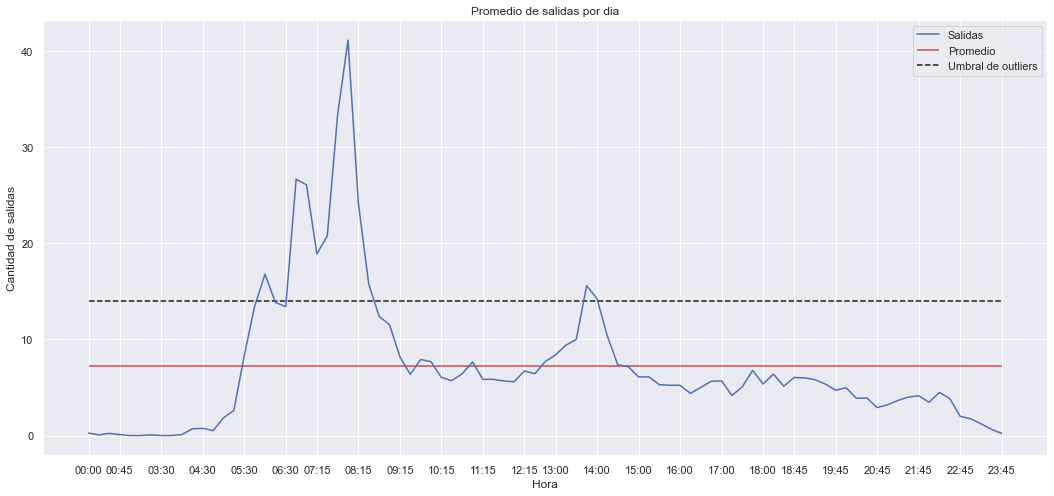

In [60]:
idx = np.linspace(0,len(df2)-1,24).astype(int)
t_labels = df2["INTERVALO"].values[idx]
dia = "Día 1"
#y = df2[dia]
y = prom_salidas_dia

fig, ax =plt.subplots(figsize=(18,8));
ax.plot(range(len(y)),y);
ax.hlines(y=y.mean(), xmin=0, xmax=len(y)-1,color="r");
ax.hlines(y=14, xmin=0, xmax=len(y)-1,color="k",linestyles="dashed");

ax.set_xticks(idx)
ax.set_xticklabels(t_labels)
ax.grid(True)
ax.set_xlabel("Hora");
ax.set_ylabel("Cantidad de salidas");
ax.set_title("Promedio de salidas por dia");
ax.legend(["Salidas","Promedio","Umbral de outliers"]);

In [36]:
print("Descripción estadística de salidas promedio por día:")
pd.Series(prom_salidas_dia).describe()

Descripción estadística de salidas promedio por día:


count    89.000000
mean      7.227256
std       7.330960
min       0.000000
25%       3.451613
50%       5.677419
75%       7.903226
max      41.096774
dtype: float64

Vemos que en las primeras y últimas horas del día la cantidad de salidas es casi nula como es de esperarse considerando los horarios de servicio de Transmilenio. Por otro lado, se ve que desde las 5:00 am aproximádamente empieza a crecer considerablemente las salidas (de 0 a 17 salidas entre las 4 y las 6 am). Luego, hay una ligera disminución y a las 6 30 hay un segundo pico que llega hasta 27 salidas. Más adelante vuelve haber un pico máximo alrededor de 41 salidas las 8:30 am, 9:00 am y luego hay un valle entre las 9 y la 1:30 pm. A la  1:45, aumentan de nuevo las salidas (de 8 a 15) y vuelve a disminuir a disminuir a unas 8 salidas. Poco a poco las salidas disminuyen hasta el final del día.

Realicemos análisis de la distribución de los puntos para detectar outliers.

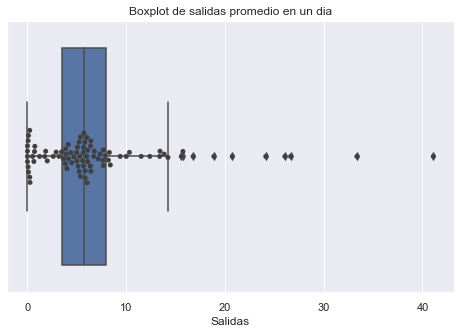

In [46]:
#plt.boxplot(prom_salidas_dia)
fig, ax = plt.subplots(figsize=(8,5))
sns.boxplot(x=prom_salidas_dia);
sns.swarmplot(x=prom_salidas_dia, color=".25");
ax.set_xlabel("Salidas")
ax.set_title("Boxplot de salidas promedio en un dia");

Según el boxplot, los  outliers de esta serie son aquellos en los que la cantidad de salidas es igual o superior a 14. Con la gráfica de arriba confirmamos que en efecto, los valores superiores a 14 corresponden a los que forman los picos de 6:00 a 8:00 am y de 1:30 pm a 2:00 pm.

In [ ]:
# Ahora se podría analizar la tendencia, estacionalidad y periodicidad de la serie promedio 
# y de la serie para los 31 dias seguidos